In [1]:
import pickle
import mgzip
import numpy as np
import matplotlib.pyplot as plt
import os

with mgzip.open('../fullE_big_noE_predictions/pred_converted_175GeV_debug_41.bin.gz') as data:
    predictions = pickle.load(data)

In [5]:
def calculate_cluster_distances(pred_beta, pred_dist, ccoords, t_d=1.):
    beta_max, beta_max_id= *[pred_beta.max()], *[pred_beta.argmax()]
    beta_max_coords = ccoords[beta_max_id]
    distances = np.sqrt((ccoords[:,0]-np.ones_like(ccoords[:,0])*beta_max_coords[0])**2 + 
                   (ccoords[:,1]-np.ones_like(ccoords[:,0])*beta_max_coords[1])**2 + 
                   (ccoords[:,2]-np.ones_like(ccoords[:,0])*beta_max_coords[2])**2)
    return (np.where(distances<t_d*pred_dist[beta_max_id],1,0), distances)

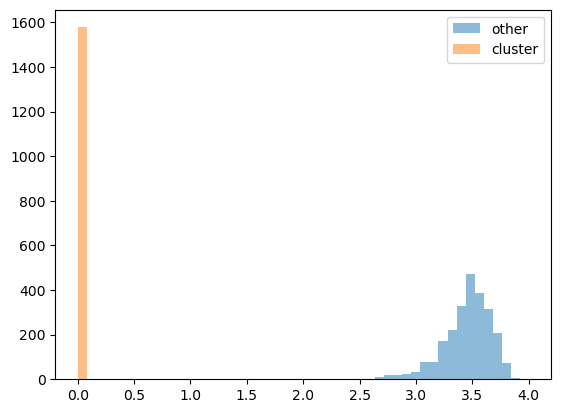

In [9]:
for event in predictions: 
    pred_id = event[2]['pred_id'].argmax(axis=1)
    pred_beta = event[2]['pred_beta']
    pred_dist = event[2]['pred_dist']
    ccoords = event[2]['pred_ccoords']
    cluster_idx, cluster_distances = calculate_cluster_distances(pred_beta, pred_dist, ccoords)
    plt.hist(cluster_distances[cluster_idx==0], bins=50, alpha=0.5, range=(0,4))
    plt.hist(cluster_distances[cluster_idx==1], bins=50, alpha=0.5, range=(0,4))
    plt.legend([r'other',r'cluster'])
    break

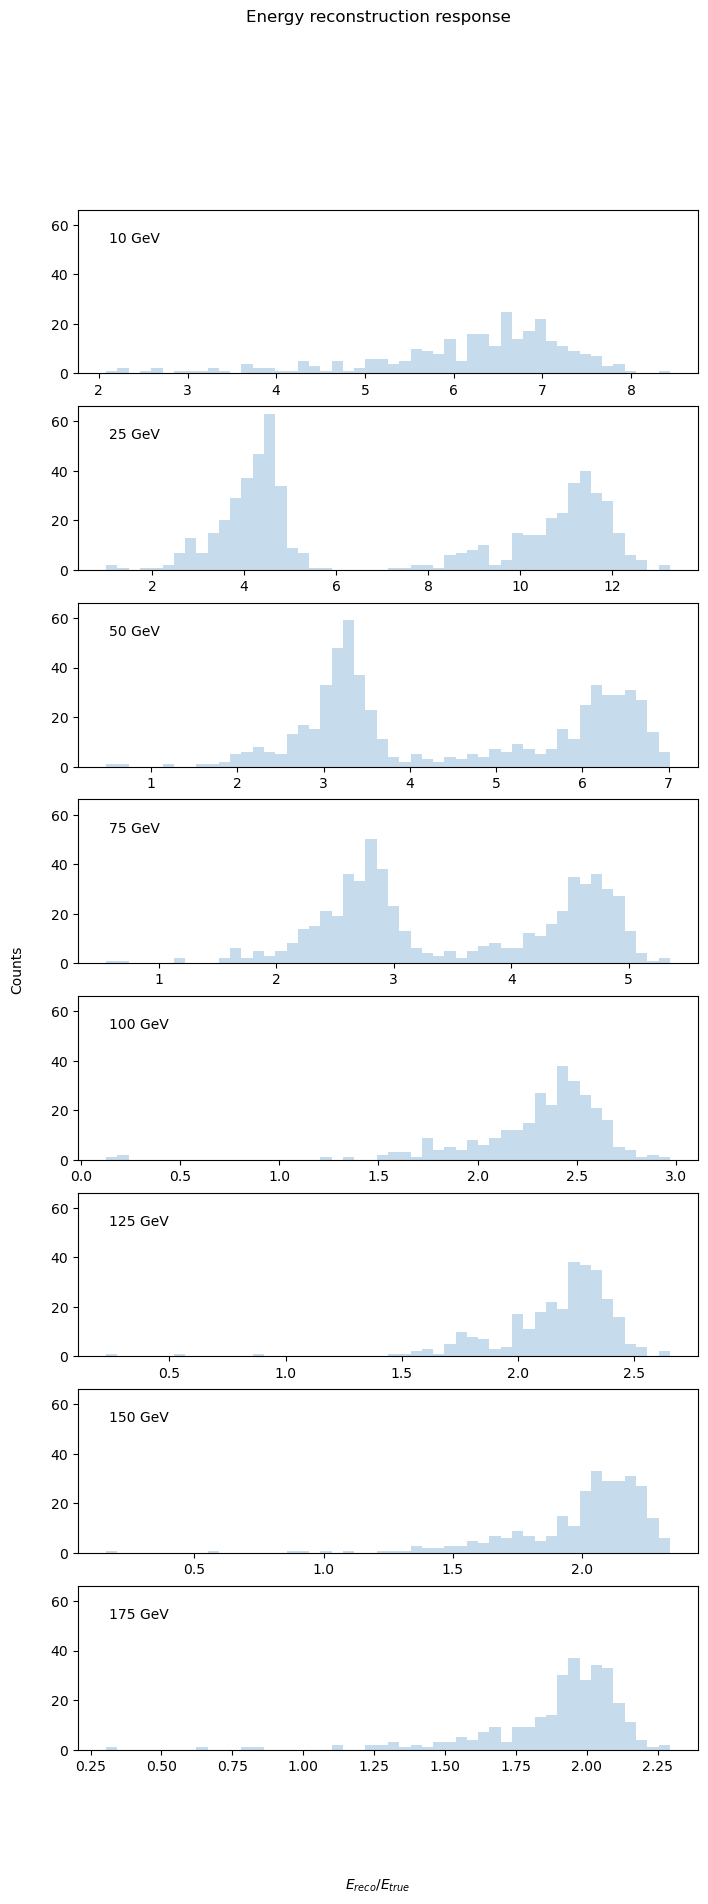

In [18]:
# Generate as many subplots as len(energy)
fig, axs = plt.subplots(8, 1, figsize=(8, 20), sharey=True)
fig.suptitle('Energy reconstruction response')
fig.text(0.5, 0.04, r'$E_{reco}$/$E_{true}$', ha='center')
fig.text(0.04, 0.5, 'Counts', va='center', rotation='vertical')

energy = [10, 25, 50, 75, 100, 125, 150, 175]

for i in range(len(energy)):

    reco_energies = []

    for fname in os.listdir('../fullE_big_noE_predictions/'):   
        if str(energy[i])+'GeV' in fname:
            with mgzip.open('../fullE_big_noE_predictions/'+fname) as predictions:
                predictions = pickle.load(predictions)  
                for event in predictions: 
                    pred_id = event[2]['pred_id'].argmax(axis=1)
                    pred_beta = event[2]['pred_beta']
                    pred_ene = event[2]['rechit_energy']
                    pred_dist = event[2]['pred_dist']
                    ccoords = event[2]['pred_ccoords']
                    cluster_idx, cluster_distances = calculate_cluster_distances(pred_beta, pred_dist, ccoords)
                    mask = cluster_idx==1.
                    reco_energies.append(pred_ene[mask].sum())

    axs[i].hist(np.array(reco_energies)/energy[i], bins=50, alpha=0.25)
    axs[i].text(0.05,0.8,str(energy[i])+' GeV', transform=axs[i].transAxes)